# Tutorial 5: Annotation of 10X Visium Breast Cancer data

The following tutorials demonstrates how to annotate the 10x Visium [Breast Cancer S2 (BCS2) dataset](https://www.10xgenomics.com/resources/datasets/human-breast-cancer-block-a-section-2-1-standard-1-1-0) with PAST using [Breast Cancer S1 (BCS1) dataset](https://www.10xgenomics.com/resources/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0) as reference.

## Prepration and data import

In [1]:
import past
import os
import scanpy as sc
import warnings
import torch
import numpy as np
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(3,3), facecolor="white")
os.environ["R_HOME"] = "/home/lizhen/miniconda3/envs/scTECH-R/lib/R"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

You can uncomment and execute the following command to download the Breast Cancer S1 and S2 datasets in AnnData format.

In [3]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/10X_BCS1.h5ad
# !wget https://health.tsinghua.edu.cn/software/PAST/data/10X_BCS2.h5ad

In [4]:
## BCS1 DATASET
BCS1 = sc.read_h5ad("/home/lizhen/code/PAST/Data/10x_BCS1.h5ad")
BCS1.var_names_make_unique()
BCS1

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'annot_type', 'fine_annot_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
## BCS2 DATASET
BCS2 = sc.read_h5ad("/home/lizhen/code/PAST/Data/10x_BCS2.h5ad")
BCS2.var_names_make_unique()
BCS2

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Training PAST model on the reference dataset

We set a random seed for all random process for reproducibility. The BCS1 serves as the reference dataset for the annotation of BCS2 dataset.

In [6]:
past.setup_seed(666)
bcs1 = BCS1.copy()

Then we preprocess BCS1 dataset `bcs1`.

In [7]:
bcs1 = past.preprocess(bcs1, min_cells=3, n_tops=3000, gene_method="gearyc")
bcs1

View of AnnData object with n_obs × n_vars = 3798 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'annot_type', 'fine_annot_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

Here we construct self-pseudo-bulk prior matrix with BCS1 itself for better training of PAST

In [8]:
rdata = BCS1.copy()
rdata = past.integration(rdata, bcs1)
rdata = past.preprocess(rdata, min_cells=None, target_sum=None, n_tops=None)
rdata = past.get_bulk(rdata, key="fine_annot_type")
rdata

add 0 zero features to reference; Current total 3000 genes
bulk_data's shape: (20, 3000)


AnnData object with n_obs × n_vars = 20 × 3000

Initialization of PAST model.

In [9]:
PAST_model = past.PAST(d_in=bcs1.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Here we train PAST with BCS1 dataset with prior matrix constructed with itself. The trained PAST model will be further used to obtain joint embeddding of reference and target dataset(s).

In [10]:
PAST_model.model_train(bcs1, rdata=rdata, epochs=50, lr=1e-3, device=device)

This dataset is smaller than batchsize so that ripple walk sampler is not used!
Epoch:10 Time:1.65s Loss: 11.882279
Epoch:20 Time:1.33s Loss: 7.121250
Epoch:30 Time:1.33s Loss: 5.802668
Epoch:40 Time:1.33s Loss: 4.719301
Epoch:50 Time:1.33s Loss: 3.957418
Epoch:60 Time:1.33s Loss: 3.334533
Epoch:70 Time:1.33s Loss: 2.844739
Epoch:80 Time:1.33s Loss: 2.434022
Epoch:90 Time:1.33s Loss: 2.057979
Epoch:100 Time:1.33s Loss: 1.713244
Epoch:110 Time:1.33s Loss: 1.424979
Epoch:120 Time:1.33s Loss: 1.211037
Epoch:130 Time:1.33s Loss: 1.022499
Epoch:140 Time:1.33s Loss: 0.885521
Epoch:150 Time:1.33s Loss: 0.772985
Epoch:160 Time:1.33s Loss: 0.672947
Epoch:170 Time:1.34s Loss: 0.583736
Epoch:180 Time:1.34s Loss: 0.510631
Epoch:190 Time:1.34s Loss: 0.471798
Epoch:200 Time:1.35s Loss: 0.452254
Epoch:210 Time:1.35s Loss: 0.440068
Epoch:220 Time:1.34s Loss: 0.429813
Model Converge


## Obtaining joint embedding of BCS1 and BCS2 dataset

We concatnate reference dataset with  target datasets through aligning the gene set of target dataset(s) to that of reference dataset with `integration()` function.

In [11]:
cdata = BCS1.copy()
cdata = past.integration(cdata, bcs1)
cdata.obs["sample_id"] = ["BCS1"] * cdata.shape[0]
adata = cdata.copy()

cdata = BCS2.copy()
cdata = past.integration(cdata, bcs1)
cdata.obs["sample_id"] = ["BCS2"] * cdata.shape[0]
adata = adata.concatenate([cdata.copy()])
adata

add 0 zero features to reference; Current total 3000 genes
add 0 zero features to reference; Current total 3000 genes


AnnData object with n_obs × n_vars = 7785 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'annot_type', 'fine_annot_type', 'sample_id', 'batch'
    obsm: 'spatial'

We preprocess the concated datasets with a unified process so that the reference dataset and target dataset(s) share the same feature space.

In [12]:
adata = past.preprocess(adata, min_cells=None)

We get the joint embedding of reference dataset and target dataset(s) with the trained PAST model.

In [13]:
embeddings = None
for sample in adata.obs["sample_id"].unique().tolist():
    cdata = adata[adata.obs["sample_id"] == sample, :]
    cdata = PAST_model.output(cdata)
    if embeddings is not None:
        embeddings = np.concatenate([embeddings, cdata.obsm["embedding"].copy()], axis=0)  
    else:
        embeddings = cdata.obsm["embedding"].copy()
adata.obsm["embedding"] = embeddings

## Annotating BCS2 dataset with SVM trained on BCS1 dataset

We annotate the target dataset(s) with SVM trained on the reference dataset.

In [14]:
bcs1 = adata[adata.obs["sample_id"]=="BCS1", :]
bcs2 = adata[adata.obs["sample_id"]=="BCS2", :]
annotation = past.svm_annotation(bcs1.obsm["embedding"].copy(),
                                 bcs1.obs["fine_annot_type"],
                                 bcs2.obsm["embedding"].copy())
adata.obs["fine_annot_type"][adata.obs["sample_id"]=="BCS2"] = annotation

Spatial visualization of the annotation result for BCS2 dataset which was obtained by supervised annotation based on PAST-derived embeddings.

... storing 'fine_annot_type' as categorical


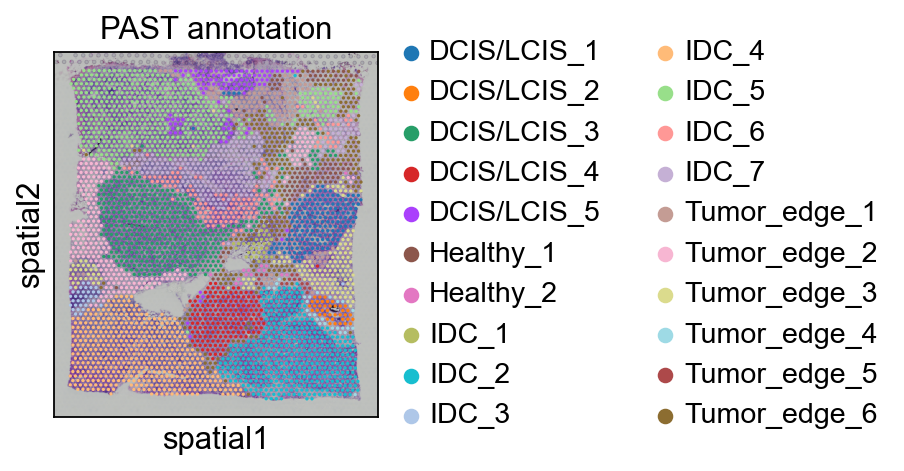

In [15]:
bcs2 = BCS2.copy()
bcs2.obs["fine_annot_type"] = annotation
sc.pl.spatial(bcs2, color=["fine_annot_type"], title=["PAST annotation"])

UMAP visualization on joint embeddings of reference dataset and target dataset(s) colored by dataset label and spatial domain label.

... storing 'sample_id' as categorical


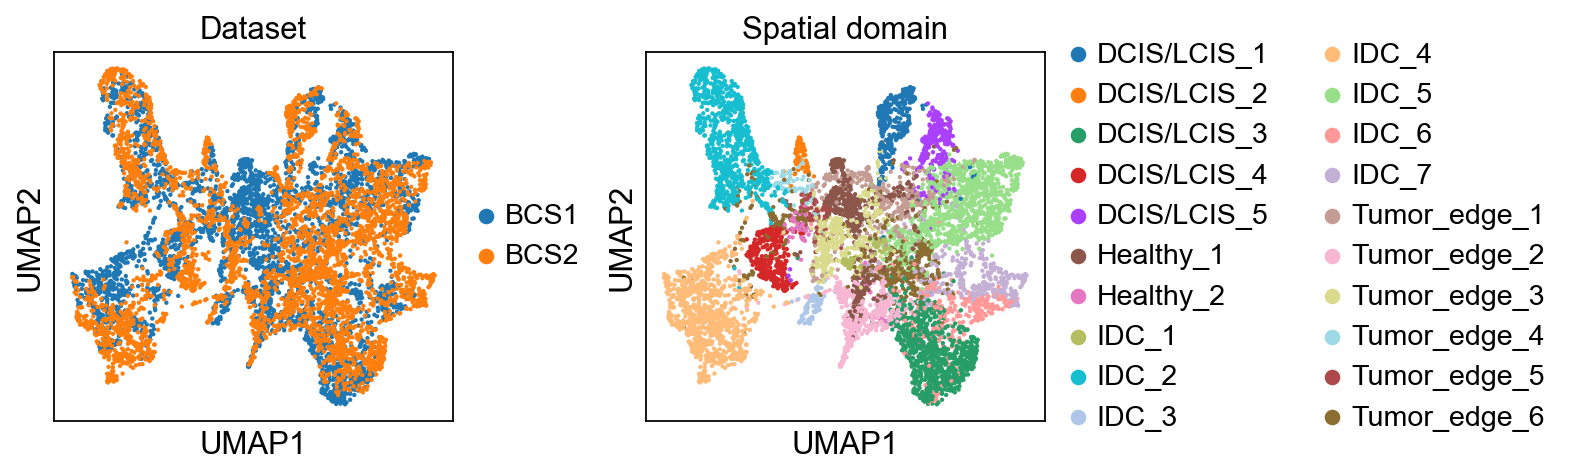

In [16]:
sc.pp.neighbors(adata, use_rep="embedding")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["sample_id", "fine_annot_type"], title=["Dataset", "Spatial domain"], wspace=0.35)